In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout, Reshape,UpSampling2D,Input
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import datetime
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# Rescale pixel values and set the target size for resizing
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

batch_size = 32
base_path = "/content/drive/MyDrive/Cancer_Dataset/lung_colon_image_set"

target_size = (256, 256)  # Assuming you want to resize to this size

# Train generator
lung_colon_train_generator = datagen.flow_from_directory(
    base_path,
    target_size=target_size,
    batch_size=batch_size,
    classes=["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"],
    shuffle=True,
    subset="training"
)

# Test/Validation generator
lung_colon_test_generator = datagen.flow_from_directory(
    base_path,
    target_size=target_size,
    batch_size=batch_size,
    classes=["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"],
    shuffle=True,
    subset="validation"
)


Found 17899 images belonging to 5 classes.
Found 4474 images belonging to 5 classes.


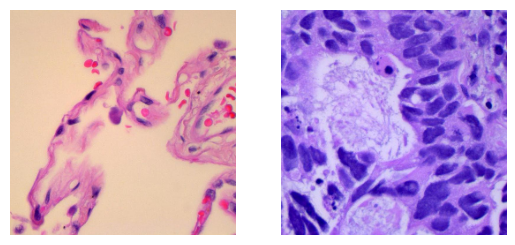

In [4]:
import matplotlib.pyplot as plt

def display_images(generator, n=2):
    x, _ = next(generator)  # Get a single batch
    for i in range(n):  # Display the first n images from this batch
        plt.subplot(1, n, i+1)
        plt.imshow(x[i])
        plt.axis('off')
    plt.show()

display_images(lung_colon_train_generator)


In [5]:
def generator_loss(_, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    return cross_entropy(tf.ones_like(fake_output) * 0.9, fake_output)  # Apply label smoothing here

def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)  # And here
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay

class GAN:
    def __init__(self, img_shape, latent_dim):
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.train_step_counter = 0
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.encoder = self.build_encoder()

    def build_generator(self):
        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        noise_dim = self.latent_dim
        model.add(layers.Dense(8*8*256, use_bias=False, input_dim=noise_dim))
        model.add(layers.Reshape((8, 8, 256)))

        for filters in [128, 64, 32, 16,8]:
            model.add(layers.UpSampling2D())
            model.add(layers.Conv2D(filters, kernel_size=3, padding='same', kernel_initializer=init))
            model.add(InstanceNormalization())
            model.add(layers.ReLU())

        model.add(layers.Conv2D(3, kernel_size=3, padding='same', activation='tanh', kernel_initializer=init))
        return model

    def build_discriminator(self):
        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()
        model.add(layers.Input((256, 256, 3)))
        model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_initializer=init))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.3))  # Reduced dropout

        for filters in [128, 64, 32, 16, 8]:
            model.add(layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_initializer=init))
            model.add(layers.BatchNormalization(momentum=0.8))
            model.add(layers.LeakyReLU(alpha=0.2))
            model.add(layers.Dropout(0.3))  # Reduced dropout

        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

    def build_encoder(self):
        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding='same', kernel_initializer=init))
        model.add(layers.LeakyReLU(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))

        for filters in [64, 128]:
            model.add(layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_initializer=init))
            model.add(layers.LeakyReLU(0.2))
            model.add(layers.BatchNormalization(momentum=0.8))

        model.add(layers.Flatten())
        model.add(layers.Dense(self.latent_dim, activation='tanh'))
        return model

    def compile(self, d_optimizer, g_optimizer, e_optimizer, d_loss_fn, g_loss_fn, e_loss_fn):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.e_optimizer = e_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.e_loss_fn = e_loss_fn

    def train_step(self, real_images, batch_size):
        # Generate random noise as an input to initialize the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images from the latent vector
            fake_images = self.generator(random_latent_vectors, training=True)
            # Get the logits for the fake images
            fake_logits = self.discriminator(fake_images, training=True)
            # Get the logits for the real images
            real_logits = self.discriminator(real_images, training=True)

            # Calculate the discriminator loss using the binary cross-entropy loss
            d_loss_fake = self.d_loss_fn(tf.zeros_like(fake_logits), fake_logits)
            d_loss_real = self.d_loss_fn(tf.ones_like(real_logits), real_logits)
            d_loss = d_loss_fake + d_loss_real

            # Calculate the generator's loss
            g_loss = self.g_loss_fn(tf.ones_like(fake_logits), fake_logits)

        # Get the gradients w.r.t the losses
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)

        # Print average gradient values to check if they are vanishing or not
        # avg_d_grads = np.mean([np.mean(g.numpy()) for g in d_grads if g is not None])  # Exclude None gradients if any
        # print(f"Avg D-Grads: {avg_d_grads}")
        del tape
        # Update the weights
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

        # Encoder training every 2 steps, you can adjust the frequency
        if self.train_step_counter % 2 == 0:
            with tf.GradientTape() as tape:
                # Encode the fake images to get the latent vector
                encoded_latent = self.encoder(fake_images, training=True)

                # Calculate the encoder's loss as mean squared error
                e_loss = self.e_loss_fn(random_latent_vectors, encoded_latent)

            # Get the gradients w.r.t the losses
            e_grads = tape.gradient(e_loss, self.encoder.trainable_weights)

            # Update the weights
            self.e_optimizer.apply_gradients(zip(e_grads, self.encoder.trainable_weights))
        else:
            e_loss = tf.constant(0.0)  # Or any other default/filler value

        self.train_step_counter += 1
        return {"d_loss": d_loss, "g_loss": g_loss, "e_loss": e_loss}

    def train(self, dataset, batch_size, epochs, steps_per_epoch):
        # Initialize a history dictionary
        self.history = {
            'd_loss': [],
            'g_loss': [],
            'e_loss': []
        }

        for epoch in range(epochs):
            for step, (real_images, _) in enumerate(dataset):
                # If step reaches the pre-determined steps per epoch, break from the loop
                if step >= steps_per_epoch:
                    break

                # Train the model
                loss_values = self.train_step(real_images, batch_size)

                # Save the loss values to the history dictionary
                self.history['d_loss'].append(loss_values['d_loss'].numpy())
                self.history['g_loss'].append(loss_values['g_loss'].numpy())
                self.history['e_loss'].append(loss_values['e_loss'].numpy())

                # Logging the losses to the console
                if step % 10 == 0:
                    print(f"Epoch: {epoch}, Step: {step}, "
                          f"D Loss: {loss_values['d_loss']}, "
                          f"G Loss: {loss_values['g_loss']}, "
                          f"E Loss: {loss_values['e_loss']}")

            # Save model weights at the end of each epoch
            self.generator.save_weights(f'/content/drive/MyDrive/Cancer_Dataset/models/generator_weights_epoch_{epoch+1}.h5')
            self.discriminator.save_weights(f'/content/drive/MyDrive/Cancer_Dataset/models/discriminator_weights_epoch_{epoch+1}.h5')
            self.encoder.save_weights(f'/content/drive/MyDrive/Cancer_Dataset/encoder_weights_epoch_{epoch+1}.h5')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:
gan = GAN((256, 256, 3),100)

gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(1e-4),
    g_optimizer=tf.keras.optimizers.Adam(1e-4),
    e_optimizer=tf.keras.optimizers.Adam(1e-4),
    d_loss_fn=discriminator_loss,
    g_loss_fn=generator_loss,
    e_loss_fn=tf.keras.losses.MeanSquaredError()
)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
Hist = gan.train( lung_colon_train_generator, 32,epochs=50, steps_per_epoch=625)

Epoch: 0, Step: 0, D Loss: 18.76028823852539, G Loss: 0.5077557563781738, E Loss: 1.5745569467544556
Epoch: 0, Step: 10, D Loss: 17.856447219848633, G Loss: 0.5853690505027771, E Loss: 1.2762646675109863
Epoch: 0, Step: 20, D Loss: 17.839345932006836, G Loss: 0.5731685161590576, E Loss: 1.0793485641479492
Epoch: 0, Step: 30, D Loss: 17.45398712158203, G Loss: 0.7069153785705566, E Loss: 0.9620097875595093
Epoch: 0, Step: 40, D Loss: 17.76154899597168, G Loss: 0.7015901207923889, E Loss: 0.8939305543899536
Epoch: 0, Step: 50, D Loss: 17.410409927368164, G Loss: 0.6763155460357666, E Loss: 0.8301085829734802
Epoch: 0, Step: 60, D Loss: 16.835586547851562, G Loss: 0.8651667833328247, E Loss: 0.7980607748031616
Epoch: 0, Step: 70, D Loss: 16.755348205566406, G Loss: 0.9925202131271362, E Loss: 0.7908013463020325
Epoch: 0, Step: 80, D Loss: 16.481130599975586, G Loss: 1.2058852910995483, E Loss: 0.7375131845474243
Epoch: 0, Step: 90, D Loss: 16.458011627197266, G Loss: 0.9509087800979614, E